# AIPI 590 - XAI | Assignment #08
### Adversarial Patch
### Rebecca Du (rrd17)



[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rrdu/AIPI-590/blob/main/HW8/AIPI590_AdversarialPatch_Brightness.ipynb)


### AI **was** used in this assignment and is cited appropriately where used.

## Overview

In this assignment, I will create different variants of one adversarial patch that becomes increasingly brighter in lightness to assess its attack success.

The contents of the notebook are as follows:
1) Initial Setup
2) ResNet34 Setup
3) Adversarial Patch Creation

**NOTE:** The code for sections 1, 2, and part of 3 are taken directly from the [adversarial_attacks_patches.ipynb](https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/adversarial-ai-example-notebooks/adversarial_attacks_patches.ipynb) from the Duke-AI-XAI Course Github.

**NOTE**: Code from Section 3 has been altered for my task

## 1) Initial Setup


In [1]:
#Imports
import os
import json
import math
import time
import numpy as np
import scipy.linalg

#For plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

from tqdm.notebook import tqdm

#Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

/tmp/ipython-input-1301154881.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Paths
#Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device cuda:0


In [4]:
import urllib.request
from urllib.error import HTTPError
import zipfile
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

Unzipping file...
Unzipping file...


## 2) ResNet34 Setup

We will use a pretrained ResNet34 that is available through Torchvision.

We will load it in and test its initial performance.

In [5]:
# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to ../saved_models/tutorial10/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:01<00:00, 54.8MB/s]


###2.1) Load ImageNet Data

We will perform attacks on ImageNet data, which we will now load in.

In [6]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### 2.2) ResNet34 Performance Check

Let's check and make sure the model performs well before creating the adversarial patch.

We will use the Top-5 metric, which indicates how many times the true label appears in the 5 top predictions of the model.

In [7]:
def eval_model(dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels)
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5

In [8]:
_ = eval_model(data_loader)

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 19.38%
Top-5 error: 4.38%


An error rate of 4.3% is pretty good!

In [9]:
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):

    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()

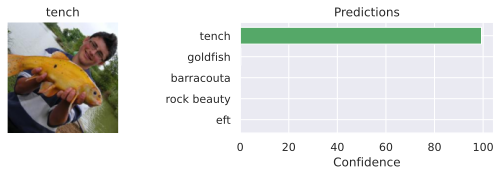

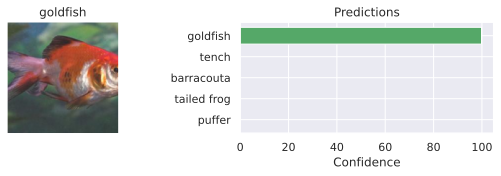

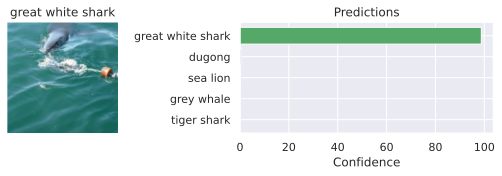

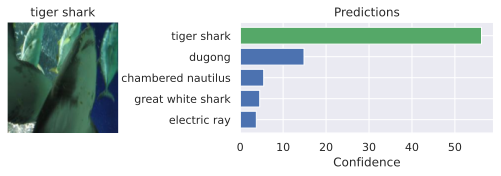

In [10]:
exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))
for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

This demonstrates the confidence of the model for each of the top 5 predicted classes.

## 3) Create Adversarial Patch

An adversarial patch is a small image that can be added onto an existing picture and cause the model to confidently predict the wrong class of our choosing.

We will follow [Tom Brown's](https://arxiv.org/pdf/1712.09665) proposed steps for creating the adversarial patch.

To create this patch, we take the following steps:
1) Calculate gradients for the input
 and update adversarial input
2) Train patch using SGD so it works for any image
3) Visualize the Patches
4) View Quantitative Results
5) Implement Attack

### 3.1) Calculate Gradients for Input and Update Adversarial Input

The function below puts the adversarial patch into every image at a random place.

In [11]:
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

The function below maps the nn.Parameter patch to the image value range of ImageNet

In [12]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

The next function brightens the patch to our desired brightness level.

In [20]:
#Code in this cell was generated by GPT-5 on 10/27/2025 at 9:18 PM
def brighten_patch(patch, factor):
  '''Returns a patch that is brighted by the factor amount'''
  with torch.no_grad():
    pixel = (torch.tanh(patch) + 1.0) / 2.0
    bright_pixel = torch.clamp(pixel * factor, min=0.0, max=1.0)
    x = 2.0 * bright_pixel - 1.0
    eps = 1e-6
    x = torch.clamp(x, min=-1.0 + eps, max=1.0-eps)
    new_patch = 0.5 * torch.log((1.0 + x) / (1.0 - x))
  return new_patch.detach()
  #End of generated code

The function below tests how many times we can fool the network to predict the target class.

In [14]:
def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

### 3.2) Train Patch with SGD

In [15]:
def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    # Leave a small set of images out to check generalization
    # In most of our experiments, the performance on the hold-out data points
    # was as good as on the training set. Overfitting was little possible due
    # to the small size of the patches.
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}

In [16]:
# If you train new patches, you can save the results via calling this function
def save_results(patch_dict):
    result_dict = {cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t
                                   for t in patch_dict[cname][psize]["results"]]
                           for psize in patch_dict[cname]}
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)

In [17]:
def get_patches(class_names, patch_sizes):
    result_dict = dict()

    # Loop over all classes and patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")
            # Load patch if pretrained file exists, otherwise start training
            if not os.path.isfile(file_name):
                patch, val_results = patch_attack(pretrained_model, target_class=c, patch_size=patch_size, num_epochs=5)
                print(f"Validation results for {name} and {patch_size}:", val_results)
                torch.save(patch, file_name)
            else:
                patch = torch.load(file_name)
            # Load evaluation results if exist, otherwise manually evaluate the patch
            if name in json_results:
                results = json_results[name][str(patch_size)]
            else:
                results = eval_patch(pretrained_model, patch, data_loader, target_class=c)

            # Store results and the patches in a dict for better access
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }

    return result_dict

In [31]:
class_names = ['cauliflower']
brightness_factors = [1.50, 2.00, 2.50]
patch_sizes = [64]

json_path = os.path.join(CHECKPOINT_PATH, 'bright_patch_results.json')

if os.path.isfile(json_path):
    with open(json_path, "r") as f:
        json_results = json.load(f)
else:
    json_results = {}

bright_patch_dict = get_patches(class_names, patch_sizes)

for cname in class_names:
  target_idx = label_names.index(cname)
  for psize in patch_sizes:
    base_entry = bright_patch_dict[cname][psize]
    base_patch = base_entry['patch']

    #Make variants dictionary
    base_entry.setdefault('variants', {})

    for brightness in brightness_factors:
      #Make bright patch
      bright_patch = brighten_patch(base_patch, brightness)

      #Evaluate
      val_loader = data_loader
      results = eval_patch(pretrained_model, bright_patch, val_loader, target_idx)

      #Store results
      base_entry['variants'][int(brightness*100)] = {
          'patch': bright_patch,
          'results': results
      }

save_results(bright_patch_dict) # Uncomment if you add new class names and want to save the new results

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

### 3.3) Visualize the Patches

Let's look at the patches now

In [32]:
def show_all_patches(patch_dict, class_names, patch_sizes):
  #Code was generated using GPT-5 on 10/27/2025 at 10:08 PM
  def to_img(param_patch):
      p = (torch.tanh(param_patch) + 1) / 2
      return np.clip(p.detach().cpu().permute(1,2,0).numpy(), 0.0, 1.0)
  #End of generated code

  for psize in patch_sizes:
    entry = patch_dict[cname][psize]
    variants = entry.get('variants', {})

    #Sort variant keys
    try:
        vkeys = sorted(variants.keys(), key=lambda x: int(str(x).rstrip('%')))
    except Exception:
        vkeys = list(variants.keys())

    cols = 1 + len(vkeys)
    fig, ax = plt.subplots(1, cols, figsize=(cols*2.4, 2.6), squeeze=False)

    #Plot base
    ax[0,0].imshow(to_img(entry['patch']))
    ax[0,0].set_title(f'{cname}, {psize}px\nbase')
    ax[0,0].axis('off')

    #Plot variants
    for j, k in enumerate(vkeys, start=1):
      vpatch = variants[k]['patch']
      ax[0,j].imshow(to_img(vpatch))
      label = f"{k}%" if isinstance(k, (int, float)) else str(k)
      ax[0,j].set_title(label)
      ax[0,j].axis('off')

    plt.tight_layout()
    plt.show()

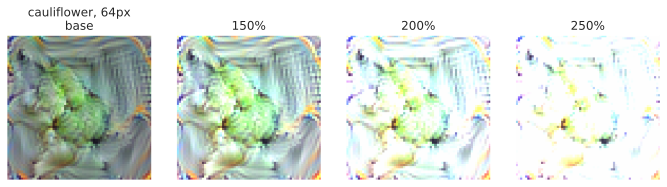

In [33]:
show_all_patches(bright_patch_dict, class_names, patch_sizes)

As the patch becomes brighter, it loses more of its defining features.

### 3.4) View Quantitative Results

In [41]:
#Code generated with GPT-5 on 10/27/2025 at 10:38 PM
def print_variant_results(patch_dict, cname, psize, keys):
  entry = patch_dict[cname][psize]
  rows = []

  #Base patch
  base_res = entry['results']

  #Start of generated code
  def _num(x):
      try: return float(x.item()) if hasattr(x, 'item') else float(x)
      except: return None

  if isinstance(base_res, (tuple, list)) and len(base_res) >= 2:
    rows.append(("base", _num(base_res[0]), _num(base_res[1])))
  elif isinstance(base_res, dict):
    rows.append(("base", _num(base_res.get('acc')), _num(base_res.get('top5'))))
  #End of generated code
  #Link to chat: https://chatgpt.com/s/t_69002cd801a4819187f75ea85838de5d

  #Variants
  for k in keys:
    if k in entry['variants']:
      res = entry['variants'][k]['results']
    elif str(k) in entry['variants']:
      res = entry['variants'][str(k)]['results']
    else:
      rows.append((f"{k}%", None, None))
      continue

    if isinstance(res, (tuple, list)) and len(res) >= 2:
      rows.append((f"{k}%", _num(res[0]), _num(res[1])))
    elif isinstance(res, dict):
      rows.append((f"{k}%", _num(res.get('acc')), _num(res.get('top5'))))
    else:
      rows.append((f"{k}%", _num(res), None))

  #Pretty print
  print(f"Results for {cname}, {psize}px")
  print(f"{'variant':>8} | {'top1':>6} | {'top5':>6}")
  print("-"*28)
  for v, a, t5 in rows:
    a = f"{a:.4f}" if a is not None else "n/a"
    t5 = f"{t5:.4f}" if t5 is not None else "n/a"
    print(f"{v:>8} | {a:>6} | {t5:>6}")

In [43]:
print_variant_results(bright_patch_dict, 'cauliflower', 64, keys=(150,200,250))

Results for cauliflower, 64px
 variant |   top1 |   top5
----------------------------
    base | 0.9862 | 0.9995
    150% | 0.9835 | 0.9994
    200% | 0.2677 | 0.4623
    250% | 0.0002 | 0.0028


What this tells us is that:
  - The original **base** patch fools the model **98.6%** of the time, meaning it has very strong performance.
  - The **150% brigher patch** still fools the model **98.35%** of the time, making it quite robust.
  - However, the performance drops off significantly with higher brightness levels, with the **200%/250% brightness patches** having **26.77% and a 0.02% success rate** in fooling the model, respectively.

### 3.5) Perform Attack

In [45]:
def perform_patch_attack(patch):
    patch_batch = exmp_batch.clone()
    patch_batch = place_patch(patch_batch, patch)
    with torch.no_grad():
        patch_preds = pretrained_model(patch_batch.to(device))
    for i in range(1,17,5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])

In [52]:
def run_patch_attack_variants(patch_dict, cname, psize,
                              brightness_keys):
    entry = patch_dict[cname][psize]
    variants = entry['variants']

    print("=== Base Patch ===")
    perform_patch_attack(entry['patch'])

    for k in brightness_keys:
      if k in variants:
        print(f"\n=== {k}% Brightness Variant ===")
        perform_patch_attack(variants[k]['patch'])
      else:
        print(f"\nVariant {k}% not found, skipping")

=== Base Patch ===


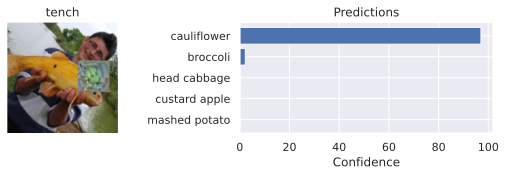

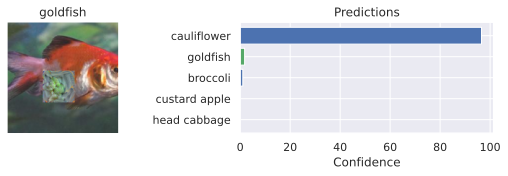

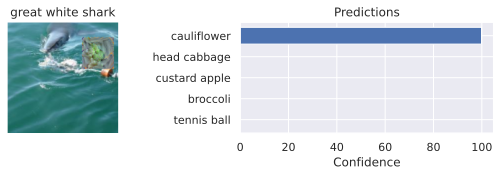

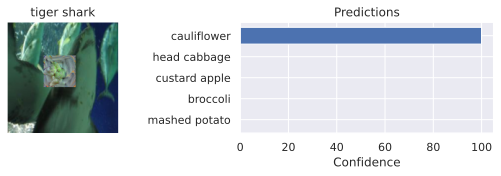


=== 150% Brightness Variant ===


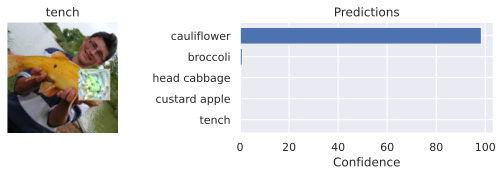

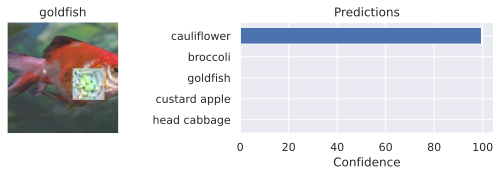

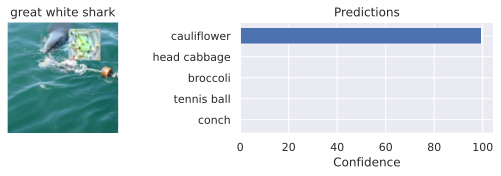

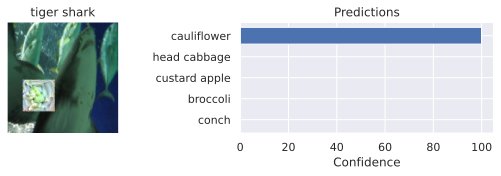


=== 200% Brightness Variant ===


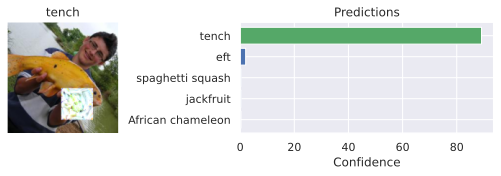

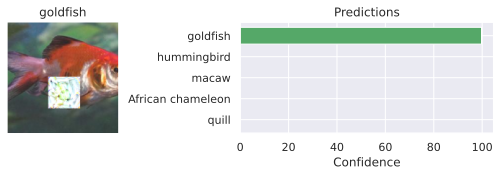

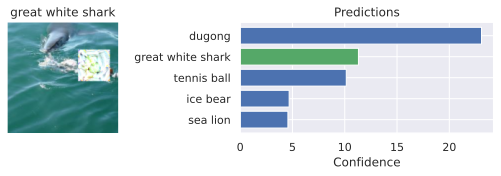

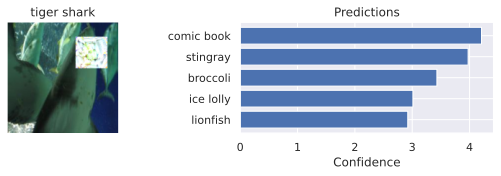


=== 250% Brightness Variant ===


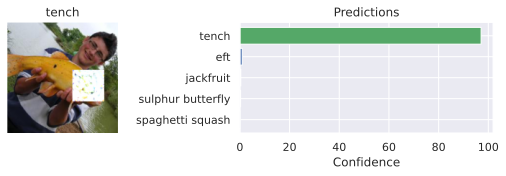

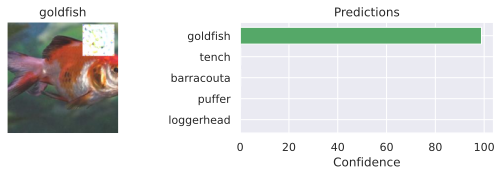

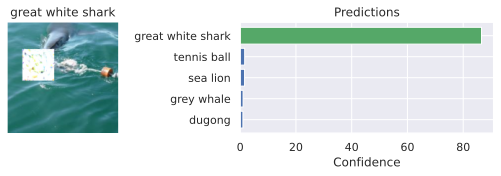

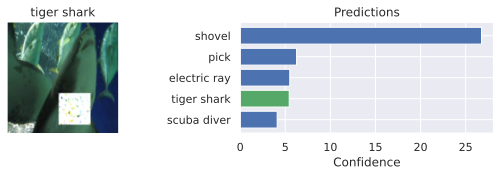

In [55]:
run_patch_attack_variants(bright_patch_dict, 'cauliflower', 64, (150, 200, 250))

As expected, we see a large dropoff in attack accuracy for the patches which are too bright.

Interestingly, they caused images to be classified not as the intended class, but also not the correct class (e.g. tiger shark -> comic book)! So, in a sense, they were successful, just misled.

### 3.6) Save Locally

#### Save Patch Dict

In [56]:
#Save bright patch dict
bright_save_path = '/content/drive/MyDrive/Colab Notebooks/AIPI590/HW8/bright_patch_dict.pt'
torch.save(bright_patch_dict, bright_save_path)
print(f'Saved to {bright_save_path}')

Saved to /content/drive/MyDrive/Colab Notebooks/AIPI590/HW8/bright_patch_dict.pt


#### Save Patch Images

In [59]:
#Turn patches into images for printing
def save_patch_images(patch_dict, class_names, patch_sizes, patch_folder):
    '''Saves each patch in patch_dict as an RGB .png image.'''
    os.makedirs(patch_folder, exist_ok=True)

    for cname in class_names:
      for psize in patch_sizes:
        entry = patch_dict[cname][psize]

        # --- save base patch ---
        base_patch = entry['patch']
        patch_img = (torch.tanh(base_patch) + 1) / 2
        patch_img = patch_img.cpu().permute(1, 2, 0).numpy()
        patch_img = np.clip(patch_img, 0.0, 1.0)
        base_img = (patch_img * 255).astype(np.uint8)
        Image.fromarray(base_img).save(
            os.path.join(patch_folder, f"{cname}_100.png")
        )
        print(f"Saved base patch -> {cname}_100.png")

        #Variants
        if "variants" in entry:
          for k, v in entry["variants"].items():
            # normalize key: remove '%' and ensure numeric string
            key_str = str(k).replace("%", "")
            patch = v["patch"]
            patch_img = (torch.tanh(patch) + 1) / 2
            patch_img = patch_img.cpu().permute(1, 2, 0).numpy()
            patch_img = np.clip(patch_img, 0.0, 1.0)
            patch_img = (patch_img * 255).astype(np.uint8)
            filename = f"{cname}_{key_str}.png"
            filepath = os.path.join(patch_folder, filename)
            Image.fromarray(patch_img).save(filepath)
            print(f"Saved variant -> {filename}")

In [60]:
import glob

def resize_for_print(path_img_folder, resized_folder, cm_size, dpi):
  '''Resizes patches to be print ready'''
  os.makedirs(resized_folder, exist_ok=True)

  #Change cm to pixels
  pixels = int((cm_size / 2.54) * dpi)

  #Go through all images in path_img_folder
  img_paths = glob.glob(os.path.join(path_img_folder, '*.png'))

  for path in img_paths:
    img = Image.open(path)

    #Resize
    img_resized = img.resize((pixels, pixels), Image.Resampling.BICUBIC)

    #Save path
    og_name = os.path.basename(path).replace('.png', f'_{cm_size}cm.png')
    save_path = os.path.join(resized_folder, og_name)

    #Save
    img_resized.save(save_path, dpi=(dpi, dpi))

    print(f'Saved to {save_path}')

In [61]:
#Save patches (normal)
patch_folder = '/content/drive/MyDrive/Colab Notebooks/AIPI590/HW8/bright_patch_images'
save_patch_images(bright_patch_dict, class_names, patch_sizes, patch_folder)

Saved base patch -> cauliflower_100.png
Saved variant -> cauliflower_150.png
Saved variant -> cauliflower_200.png
Saved variant -> cauliflower_250.png


In [63]:
#Save patches (print ready)
resized_folder = '/content/drive/MyDrive/Colab Notebooks/AIPI590/HW8/bright_patch_images_print'
resize_for_print(
    patch_folder,
    resized_folder,
    cm_size=3,
    dpi=300
)

Saved to /content/drive/MyDrive/Colab Notebooks/AIPI590/HW8/bright_patch_images_print/cauliflower_100_3cm.png
Saved to /content/drive/MyDrive/Colab Notebooks/AIPI590/HW8/bright_patch_images_print/cauliflower_150_3cm.png
Saved to /content/drive/MyDrive/Colab Notebooks/AIPI590/HW8/bright_patch_images_print/cauliflower_200_3cm.png
Saved to /content/drive/MyDrive/Colab Notebooks/AIPI590/HW8/bright_patch_images_print/cauliflower_250_3cm.png
